In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm
from pandas.api.types import CategoricalDtype

import matplotlib as mpl

In [2]:
data_dir = Path('/Volumes/REA/Data/fast_folders/')


In [3]:
if Path('vamps.h5').exists():
    df = pd.read_hdf('vamps.h5', key='vamps')
else:
    all_dfs = []
    for prot, name in zip(funcs.PROTEIN_DIRS, funcs.PROTEIN_LABELS):
        protein_dir = data_dir.joinpath(prot)
        if protein_dir.exists():
            results_paths = list(protein_dir.rglob('*.h5'))
            if len(results_paths) > 0: 
                df = funcs.get_results_df(results_paths, results='vamps')
                df['protein'] = name
                df['protein_dir'] = prot

                all_dfs.append(df)
    df = pd.concat(all_dfs)
    df.to_hdf('vamps.h5', key='vamps')

Subset according to chosen lag and chosen number of dominant processes

In [4]:
chosen_lags = pd.read_hdf('chosen_lag_times.h5', key='chosen_lags')
chosen_dom_procs = pd.read_hdf('chosen_num_dominant.h5', key='chosen_num_dominant')

lags_dict = dict(zip(chosen_lags['protein'], chosen_lags['lag']))
proc_dict = dict(zip(chosen_dom_procs['protein'], chosen_dom_procs['num_its']))

df['choose_lag'] = df['protein'].apply(lambda x: lags_dict[x])
df['choose_k'] = df['protein'].apply(lambda x: proc_dict[x])
df['choose_method'] = 'VAMP2'

df = df.loc[(df.lag == df.choose_lag) & (df.k == df.choose_k) & (df.method == df.choose_method), : ]

In [5]:
df.feature__value.unique()

array(['dihedrals', 'distances'], dtype=object)

In [11]:
def f(x):
    if x['feature__value'] == 'dihedrals':
        return 'dihed.'
    if x['feature__value'] == 'distances':
        if x['distances__transform'] == 'linear': 
            return 'dist.'
        elif x['distances__transform'] == 'logistic':
            return 'logit(dist.)'
        
df['feature'] = df.apply(f, axis=1)

Create rank based on median response

In [12]:
vamp_df = df.groupby(['protein', 'hp_index'], as_index=False).agg(
                            median = ("value", lambda x: np.quantile(x, 0.5)), 
                            lower = ("value", lambda x: np.quantile(x, 0.025)), 
                            upper = ("value", lambda x: np.quantile(x, 0.975)), 
                            feature = ("feature", lambda x: x.values[0]))

vamp_df['hp_rank'] = vamp_df.groupby(['protein'], as_index=False)['median'].rank(ascending=False)
vamp_df['lb_err'] = vamp_df['median'] - vamp_df['lower']
vamp_df['ub_err'] = vamp_df['upper'] - vamp_df['median']

# not ordered - but done to make coloring consistent
cat_type = CategoricalDtype(categories = np.sort(vamp_df.feature.unique()), ordered=True)
vamp_df['feature'] = vamp_df['feature'].astype(cat_type)

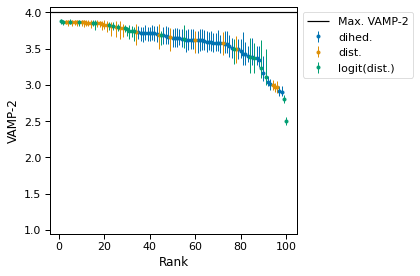

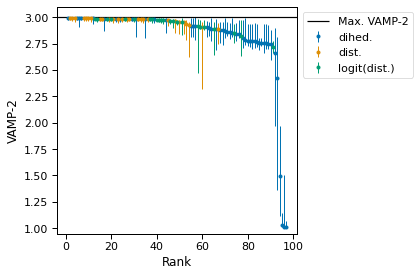

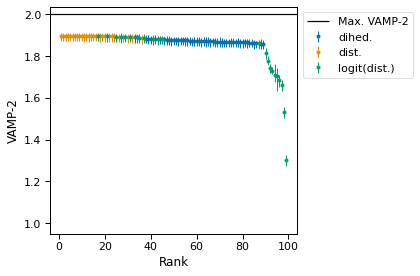

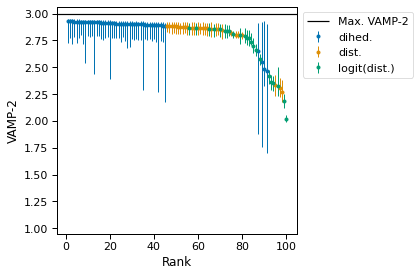

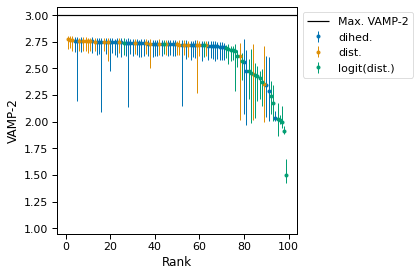

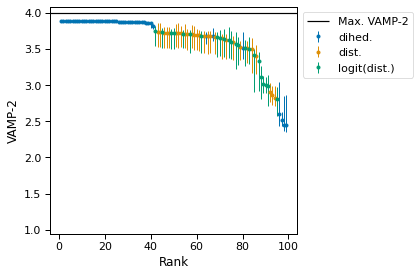

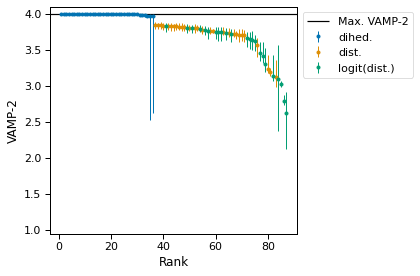

In [17]:

for label in ['BBA', 'BBL', 'Chignolin', 'Trp-cage', 'Villin', 'WW-domain', 'Homeodomain']:
    with sns.plotting_context('paper', font_scale=1.25):

        fig, ax = plt.subplots(1) #n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

        ylabel = 'VAMP-2'
        xlabel = 'Rank'

        tmp = vamp_df.loc[vamp_df.protein==label, :]

        ax.set_ylabel(ylabel)    
        ax.set_xlabel(xlabel)

        for code, cat in enumerate(tmp.feature.cat.categories):
            ix = tmp.feature == cat
            x = tmp.loc[ix, 'hp_rank']
            y = tmp.loc[ix, 'median']
            yerr = tmp.loc[ix, ['lb_err', 'ub_err']].values.T
            ax.errorbar(x, y, yerr, lw=0, marker='o', elinewidth=1, c=funcs.cols[code], ms=3, label=cat)

        if label in proc_dict.keys():
            xlim = ax.get_xlim()
            ax.hlines(proc_dict[label], *xlim, color='k', label='Max. VAMP-2')
            ax.set_xlim(xlim)
        ylim = ax.get_ylim()
        ax.set_ylim(0.95, ylim[1])
        ax.legend(bbox_to_anchor=(1, 1))

        plt.tight_layout()
        plt.savefig(funcs.FIG_DIR.joinpath(f'{label}_vamp_scores_ranked.pdf'), bbox_inches='tight')

## Save key trials

Save the best trial per feature and the worst trial

In [50]:
# vamp_df['intra_feature_rank'] = vamp_df.groupby(['protein', 'feature'])['median'].rank(ascending=False)

# hp_cols = [x for x in list(df.columns) if '__' in x]
# hp_df = df.loc[:, hp_cols+['hp_index', 'protein', 'protein_dir', 'lag', 'k']].drop_duplicates()

# best_per_feature = vamp_df.loc[vamp_df.intra_feature_rank == 1.0, :]

# grps = vamp_df.groupby(['protein'], as_index=False)
# worst_per_protein = grps.apply(lambda g: g[g['hp_rank']==g['hp_rank'].max()])
# worst_per_protein.reset_index(inplace=True, drop=True)

# key_trials = pd.concat([best_per_feature, worst_per_protein], axis=0)
# key_trials = key_trials.merge(hp_df, on=['protein', 'hp_index'], how='left')


# key_trials.sort_values(by=['protein', 'hp_rank'], inplace=True)
# key_trials['feature'] = key_trials['feature'].astype(str)

# key_trials.loc[:, ['protein', 'protein_dir',  'lag', 'k', 'hp_index', 'hp_rank', 'feature']+hp_cols].to_hdf('best_hps_per_feature.h5' , key='best_hps_per_feature')

In [14]:
# df.to_hdf('vamps_and_hps.h5', key='vamps_hps')